# `GCtree` and `dnapars` timing experiments

Runtime data for this experiment was generated by capturing scons timing log data for simulated runs with various numbers of cells (_N_). From the `GCtree` directory, run:
```bash
$ for N in 50 100 150 200 250 300 350 400 450 500
  do
      scons --simulate --outdir=working/timetest.$N --lambda=1.5 --lambda0=.25 --N=$N --nsim=20 --debug=time
  done | grep "Command execution time" | cut -f4- -d" " > notebooks/runtime_experiment.data.log
```
The branching parameters process parameters `--lambda=1.5` and `--lambda0=.25` are set according to summary statistics on real data as described in the manuscript. Output is stored in the directory `working/`. Note that this will probably take a while.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor, ceil, log10

In [3]:
"""
load timing logfile into pandas data frame
"""
df = pd.read_csv('runtime_experiment.data.log', delimiter=" ", header=None, names=('computation step', 'runtime (min)', 'units'))
df['runtime (min)'] = df['runtime (min)']/60
df = df[df['computation step'].str.endswith('dnapars/log.log:') | df['computation step'].str.endswith('gctree.inference.log:')]
df['run'] = df['computation step'].str.extract('working/timetest.[0-9]+/[.0-9]+/[.0-9]+/(?P<trial>[0-9]+)/', expand=False)
df['number of cells'] = df['computation step'].str.extract('working/timetest.(?P<N>[0-9]+).', expand=False)
df['number of cells'] = pd.to_numeric(df['number of cells'])
df.loc[df['computation step'].str.endswith('dnapars/log.log:'), 'computation step'] = 'dnapars'
df.loc[df['computation step'].str.endswith('gctree.inference.log:'), 'computation step'] = 'GCtree'

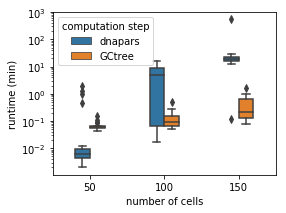

In [4]:
"""
GCtree runtime for different number of cells
"""
plt.figure(figsize=(4, 3))
sns.boxplot(x='number of cells', y='runtime (min)', hue='computation step',
            data=df.reset_index(), width=0.4)
# sns.stripplot(x='number of cells', y='runtime (min)', hue='computation step',
#             data=df.reset_index(), dodge=True, edgecolor='gray', linewidth=1)
plt.yscale('log')
plt.show()

In [5]:
"""
pivot to get timing columns for each computation step
"""
df2 = df.pivot_table(index=('number of cells', 'run'), columns='computation step', values='runtime (min)')
df2.columns = [method + ' runtime (min)' for method in df2.columns]

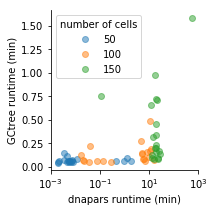

In [6]:
"""
plot GCtree runtime vs dnapars runtime for different number of cells
"""
g = sns.lmplot(x='dnapars runtime (min)', y='GCtree runtime (min)', hue='number of cells',
           data=df2.reset_index(), size=3, legend_out=False,
           fit_reg=False, scatter_kws=dict(alpha=.5, clip_on=False))
bounds = (10**floor(log10(min(df2['dnapars runtime (min)']))),
          10**ceil(log10(max(df2['dnapars runtime (min)']))))
# plt.plot(bounds, bounds, ls="--", c=".3")
g.fig.get_axes()[0].set_xscale('log')
# g.fig.get_axes()[0].set_yscale('log')
g.fig.get_axes()[0].set_xlim(bounds)
# g.fig.get_axes()[0].set_ylim(bounds)
plt.show()